# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 4
# Regularization, High Dimensionality, PCA


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A): 109A

Import libraries:

In [589]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

sns.set_context('poster')

# Continuing Bike Sharing Usage Data

In this homework, we will focus on multiple linear regression, regularization, dealing with high dimensionality, and PCA. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See Homework 3 for more information about the data.

*Note: please make sure you use all the processed data from HW 3 Part (a)...you make want to save the data set on your computer and reread the csv/json file here.


In [638]:
# FROM HW3 READING IN DATA AND CLEANING IT
train = pd.read_csv('Bikeshare_train.csv', index_col=0)
test = pd.read_csv('Bikeshare_test.csv', index_col=0)

# list of all categorical variables and lables for them
cat_preds = ['season', 'month', 'day_of_week', 'weather']
labels = [['summer', 'fall', 'winter'],['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec'], 
          ['mon', 'tue', 'wed','thu', 'fri','sat'], ['cloud', 'light']]

# loop through categorical variables and convert to one-hot encoding
for i,pred in enumerate(cat_preds): 
    dum = pd.get_dummies(train[pred])
    del dum [1]
    dum.columns = labels[i]
    train = train.join(dum)
    del train[pred]

# Repeat the same process for test data
for i,pred in enumerate(cat_preds): 
    dum = pd.get_dummies(test[pred])
    del dum [1]
    dum.columns = labels[i]
    test = test.join(dum)
    del test[pred]
    
# Mean and STD of continuous preidctors based on trainig set
temp_std = train['temp'].std(axis = 0)
temp_mean = train['temp'].mean(axis = 0)
atemp_std = train['atemp'].std(axis = 0)
atemp_mean = train['atemp'].mean(axis = 0)
humidity_std = train['humidity'].std(axis = 0)
humidity_mean = train['humidity'].mean(axis = 0)
wind_std = train['windspeed'].std(axis = 0)
wind_mean = train['windspeed'].mean(axis = 0)

# normalize training data
train['temp'] = (train['temp'] - temp_mean) / temp_std
train['atemp'] = (train['atemp'] - atemp_mean) / atemp_std
train['humidity'] = (train['humidity'] - humidity_mean) / humidity_std
train['windspeed'] = (train['windspeed'] - wind_mean) / wind_std
# normalize test data
test['temp'] = (test['temp'] - temp_mean) / temp_std
test['atemp'] = (test['atemp'] - atemp_mean) / atemp_std
test['humidity'] = (test['humidity'] - humidity_mean) / humidity_std
test['windspeed'] = (test['windspeed'] - wind_mean) / wind_std

## Part (f): Regularization/Penalization Methods

As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:

In [639]:
#--------  sample
# A function to select a random sample of size k from the training set
# Input: 
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data)
#      k (size of sample) 
# Return: 
#      chosen sample of predictors and responses

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
    
    return (x_subset, y_subset)

- Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.
- Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials for each training sample size. Also, compute the standard deviation (SD) in each case.
- Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**. Make a similar plot for the test $R^2$ scores.

How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values. You may use the `plt.errorbar` function to plot confidence bars for the average $R^2$ scores.

In [640]:
alphaOps = [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000, 100000]
y = train_set['count']
x = list(train_set.columns)
x.remove('count')
X = sm.add_constant(train_set[x])
X_test = sm.add_constant(test_set[x])
model = RidgeCV(alphas=alphaOps, fit_intercept=False).fit(X, y)
r2 = model.score(X_test, test_set['count'])
print('Ridge')
print('Best alpha by cross-validation is',model.alpha_)
print('With an R^2 score of %f'%r2)
coefs = []
# for pretty printing of coefficients and names
for param in range(len(x)):
    coefs.append((x[param], model.coef_[param + 1]))
coefs.append(('Constant', model.coef_[0]))
coefs 

Ridge
Best alpha by cross-validation is 10.0
With an R^2 score of 0.588236


[('holiday', 190.28648060467094),
 ('workingday', 892.31877511641574),
 ('temp', 591.26042368087019),
 ('atemp', 439.77437453706375),
 ('humidity', -612.31877634960415),
 ('windspeed', -266.39881746252854),
 ('summer', 735.00996494291337),
 ('fall', 724.82079895252139),
 ('winter', 1092.5593870564796),
 ('Feb', 88.599016802005394),
 ('Mar', 401.42104591236296),
 ('Apr', 476.76004988645974),
 ('May', 314.05647793012207),
 ('Jun', -79.329032239740229),
 ('Jul', -320.46635009341713),
 ('Aug', 35.653263521271299),
 ('Sep', 878.077883132593),
 ('Oct', 779.18670771912889),
 ('Nov', 291.12455560640069),
 ('Dec', 53.820500860826996),
 ('mon', 607.11133583921026),
 ('tue', 62.197794983920062),
 ('wed', 305.48790358012155),
 ('thu', 192.50459950222688),
 ('fri', 145.99203044757559),
 ('sat', 970.34384503404215),
 ('cloud', 128.8236745771826),
 ('light', -575.7805625601361),
 ('Constant', 2660.06043659434)]

In [641]:
alphaOps = [.00001, .0001, .001, .01, .1, 1, 10, 100, 1000, 10000, 100000]
model = LassoCV(alphas=alphaOps, fit_intercept=False).fit(X, y)
r2 = model.score(X_test, test_set['count'])
print('Lasso')
print('Best alpha by cross-validation is',model.alpha_)
print('With an R^2 score of %f'%r2)
coefs = []
for param in range(len(x)):
    coefs.append((x[param], model.coef_[param + 1]))
coefs.append(('Constant', model.coef_[0]))
coefs 

Lasso
Best alpha by cross-validation is 10.0
With an R^2 score of 0.573091


[('holiday', -105.26541702614622),
 ('workingday', 275.94040411716821),
 ('temp', 860.06836566139373),
 ('atemp', 247.91089162027987),
 ('humidity', -560.26351425291386),
 ('windspeed', -259.25749895205627),
 ('summer', 731.30491379633929),
 ('fall', 446.89710026836985),
 ('winter', 998.67770566510274),
 ('Feb', -0.0),
 ('Mar', 251.68672976921627),
 ('Apr', 283.48231902636257),
 ('May', 0.0),
 ('Jun', -229.20090993738194),
 ('Jul', -469.08846880129641),
 ('Aug', -0.0),
 ('Sep', 955.40687090638255),
 ('Oct', 768.90690825539218),
 ('Nov', 168.20692169174234),
 ('Dec', -0.0),
 ('mon', -0.0),
 ('tue', -0.0),
 ('wed', 166.04978968242904),
 ('thu', 7.6874828534301907),
 ('fri', 0.0),
 ('sat', 414.73263944538132),
 ('cloud', -6.8311169614631764),
 ('light', -1083.9427706381966),
 ('Constant', 3664.2354919960489)]

In [642]:
y = train['count']
y_test = test['count']
x = list(train.columns)
x.remove('count')
X = train[x]
X_test = sm.add_constant(test[x])
columns = ['mean', 'SD', 'Test', 'Type', 'Samples']
r2Data = []

# Loop 10 trials for samples sizes between 100-400 by 50
for num in range(100, 401, 50):
    r2_linear_train = []
    r2_linear_test = []
    r2_ridge_train = []
    r2_ridge_test = []
    r2_lasso_train = []
    r2_lasso_test = []
    for i in range(10):
        # Sample data and process for regression
        sampleX, sampleY = sample(X.as_matrix(), y, num)
        sampleX = sm.add_constant(sampleX)
        
        # Run 3 types of regression and store train and test r^2
        model = sm.OLS(sampleY, sampleX).fit()
        r2_linear_train.append(r2_score(y_true=sampleY, y_pred= model.predict(sampleX)))
        r2_linear_test.append(r2_score(y_true=y_test, y_pred= model.predict(X_test)))
        
        model = RidgeCV(alphas=alphaOps, fit_intercept=False).fit(sampleX, sampleY)
        r2_ridge_train.append(model.score(sampleX, sampleY))
        r2_ridge_test.append(model.score(X_test, y_test))
        
        model = LassoCV(alphas=alphaOps, fit_intercept=False).fit(sampleX, sampleY)
        r2_lasso_train.append(model.score(sampleX, sampleY))
        r2_lasso_test.append(model.score(X_test, y_test))
        
    
    r2Data += [[np.mean(r2_linear_train),np.std(r2_linear_train),0,'Linear',num],
                [np.mean(r2_linear_test),np.std(r2_linear_test),1,'Linear',num],
                [np.mean(r2_ridge_train),np.std(r2_ridge_train),0,'Ridge',num],
                [np.mean(r2_ridge_test),np.std(r2_ridge_test),1,'Ridge',num],
                [np.mean(r2_lasso_train),np.std(r2_lasso_train),0,'Lasso',num],
                [np.mean(r2_lasso_test),np.std(r2_lasso_test),1,'Lasso',num],]
    
r2Data = pd.DataFrame(data = r2Data, columns = columns)

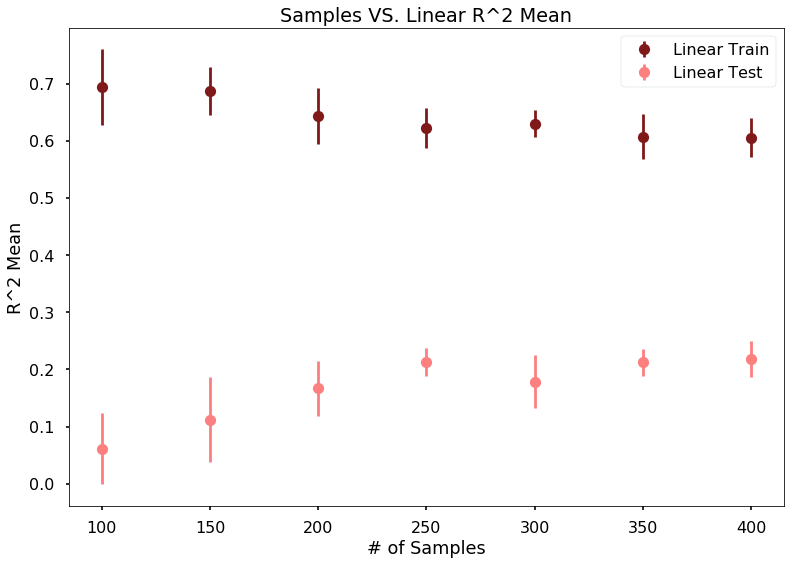

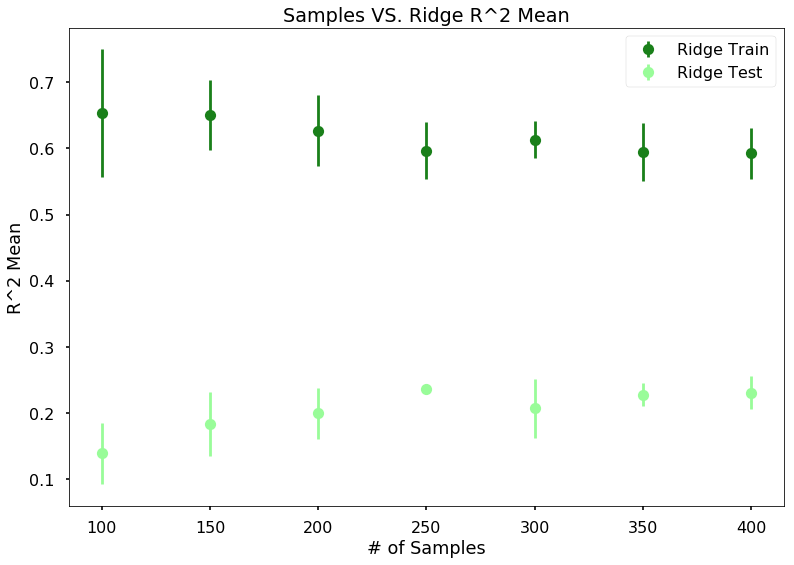

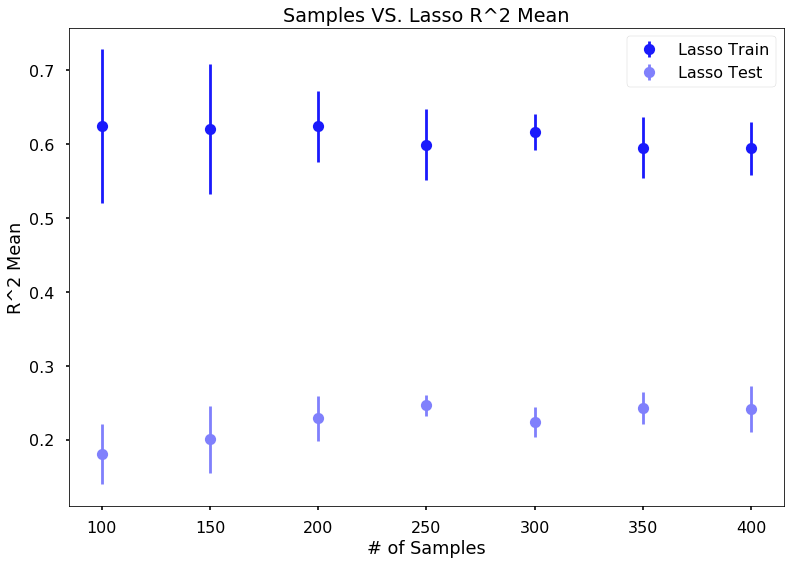

In [643]:
linearData = r2Data[r2Data['Type'] == 'Linear']
ridgeData = r2Data[r2Data['Type'] == 'Ridge']
lassoData = r2Data[r2Data['Type'] == 'Lasso']

LinTran = plt.errorbar(linearData['Samples'][linearData['Test'] == 0], linearData['mean'][linearData['Test'] == 0], 
                      linearData['SD'][linearData['Test'] == 0], c = (0.5, 0.1, 0.1), label = 'Linear Train', fmt = 'o')
LinTest = plt.errorbar(linearData['Samples'][linearData['Test'] == 1], linearData['mean'][linearData['Test'] == 1], 
                      linearData['SD'][linearData['Test'] == 1], c = (0.99, 0.5, 0.5), label = 'Linear Test', fmt = 'o')
plt.title('Samples VS. Linear R^2 Mean')
plt.xlabel('# of Samples')
plt.ylabel('R^2 Mean')
plt.legend(handles=[LinTran, LinTest])
plt.show()

RidgeTran = plt.errorbar(ridgeData['Samples'][ridgeData['Test'] == 0], ridgeData['mean'][ridgeData['Test'] == 0], 
                        ridgeData['SD'][ridgeData['Test'] == 0], c = (0.1, 0.5, 0.1), fmt = 'o', label = 'Ridge Train')
RidgeTest = plt.errorbar(ridgeData['Samples'][ridgeData['Test'] == 1], ridgeData['mean'][ridgeData['Test'] == 1], 
                        ridgeData['SD'][ridgeData['Test'] == 1], c = (0.6, 0.99, 0.6), fmt = 'o', label = 'Ridge Test')
plt.title('Samples VS. Ridge R^2 Mean')
plt.xlabel('# of Samples')
plt.ylabel('R^2 Mean')
plt.legend(handles=[RidgeTran, RidgeTest])
plt.show()

plt.title('Samples VS. Lasso R^2 Mean')
plt.xlabel('# of Samples')
plt.ylabel('R^2 Mean')
plt.legend(handles=[LasTran, LasTest])
LasTran = plt.errorbar(lassoData['Samples'][lassoData['Test'] == 0], lassoData['mean'][lassoData['Test'] == 0], 
             lassoData['SD'][lassoData['Test'] == 0], fmt='o', c = (0.1, 0.1, 0.99), label = 'Lasso Train')
LasTest = plt.errorbar(lassoData['Samples'][lassoData['Test'] == 1], lassoData['mean'][lassoData['Test'] == 1], 
             lassoData['SD'][lassoData['Test'] == 1], fmt='o', c = (0.5, 0.5, 0.99), label = 'Lasso Test')
plt.legend(handles=[LasTran, LasTest])
plt.show()

**How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) from HW 3?**

The ridge regression outputed very similar estimated coefficients to the plain linear regression in Part(b) from HW3. They are not exactly the same, but negative coefficients are still negative and possitives still possitive, while the comparitave magnitude of the coeffieceints are still very comporable. However, lasso regression computes the estimated coefficients to be quite different and reduces some of them to a zero-value. This makes sense as lasso regression both uses the shrinkage parameter as well as does parameter selection and can get rid of highly correlated parameters (months and seasons for example).

**Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.**
 
Obviously there is going to be a difference between the coefficients estimated by the two shrinkage methods as ridge and lasso regression use different penalty functions. On top of that, lasso regression will zero out highly correlated parameters, getting rid of redundant ones. Once some of the parameters are zeroed out, the others may change (especially magnitude) to adjust for that.

**List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?**

The lasso regression zeroed out the following parameters: Feb, May, Aug, Dec, mon, tue, and fri. These predictors somewhat match the redundant predictors identified in Part(c) from HW3. For example, the lasso regression eliminates some of the days of the week and months of the year which were marked as redundant in Part(c) of HW3, but not all of the redundant parameters like temp and atemp.


**Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors temp and atemp? If so, explain the reason for the difference.**

Ridge regression more evenly assigns coefficients to both temp and atemp, while lasso regression favors temp over atemp by giving it a much larger coefficient. This makes sense as lasso regression will perform predictor selection whereas ridge regression does not. This shows as lasso regression favors temp over atemp, two highly correlated predictors, but ridge regression evenly splits the importance even though they're very highly correlated.

**How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations.**

The training $R^2$ scores are much much high for the training data vs the test data. This makes sense in general because our predicted coefficients should work very well on the data the model was trained on but not as well on all the test data. Also, in general over the three different methods, as the number of samples increases, the train $R^2$ decreases while the test $R^2$ increases. This also makes sense because a larger training set will lead to better results on the test set as there is more data to train over, but the training $R^2$ will decrease because the predictos are being tested over a larger set (even if its just trainng data).

**How do the confidence intervals for the estimated $R^2$ change with training sample size?**

As the sample size increases, the estimated test $R^2$ for all three methods decreases, which makes sense as we're training over a larger set of data. On the other hand, the training $R^2$ decreases until 250 samples for all three then increases again. This also makes sense because we are testing on the same data we're training with, so we best fit the data when we have a large but not too large data set. As the data set gets too large, the predictors are worse off in general with all the training data becasue there are a large amount of points.

**Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?**

The plots show that the ridge and lasso outperform the linear method, and I would choose the lasso method because the average $R^2$ on the test data with small training samples is higher than the average for the ridge method; however, the standard deviation is higher with lasso. But, I think the higher average outweights the higher standard deviation as it will be a better model on average.

## Part (g): Polynomial & Interaction Terms

Moving beyond linear models, we will now try to improve the performance of the regression model in Part (b) from HW 3 by including higher-order polynomial and interaction terms. 

- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

In [644]:
continuousx = ['temp', 'atemp', 'humidity', 'windspeed']
x = list(train.columns)
x.remove('count')
X = train[x]
X_test = test[x]

for column in continuousx:
    # Build Column Names
    column2 = column + '^2'
    column3 = column + '^3'
    column4 = column + '^4'
    x += [column2] + [column3] + [column4]
    X2 = []
    X3 = []
    X4 = []
    # Create new polynomial terms
    for val in X[column]:
        X2.append(val**2)
        X3.append(val**3)
        X4.append(val**4)
    # Add new terms to data frame
    X = X.assign(column2=X2)
    X = X.assign(column3=X3)
    X = X.assign(column4=X4)
    X.columns = x
    
    # repeat for test 
    X2 = []
    X3 = []
    X4 = []
    for val in X_test[column]:
        X2.append(val**2)
        X3.append(val**3)
        X4.append(val**4)
    X_test = X_test.assign(column2=X2)
    X_test = X_test.assign(column3=X3)
    X_test = X_test.assign(column4=X4)
    X_test.columns = x

In [645]:
X_poly_train = X 
X = sm.add_constant(X)
X_poly_test = X_test
X_test = sm.add_constant(X_test)
model = sm.OLS(y, X).fit()

In [646]:
r2_test = r2_score(y_true=test['count'], y_pred= model.predict(X_test))
print('R^2 score on test set = %f'%r2_test)

R^2 score on test set = 0.277238


In [647]:
# Extract all coeficients with p values below .05 and print them
list(zip(model.pvalues[model.pvalues < .05].axes[0], np.round(model.params[model.pvalues < .05].values)))

[('const', 4117.0),
 ('holiday', 635.0),
 ('workingday', 1176.0),
 ('humidity', -669.0),
 ('windspeed', -447.0),
 ('fall', 1579.0),
 ('winter', 1523.0),
 ('Jun', -1456.0),
 ('Aug', -1716.0),
 ('mon', 918.0),
 ('sat', 1389.0),
 ('temp^2', -1811.0)]

In [600]:
x = list(train.columns)
x.remove('count')
X = train[x]
X = sm.add_constant(X)
X_test = test[x]
X_test = sm.add_constant(X_test)

new1 = []
new2 = []
x = ['const'] + x + ['intTerm1'] + ['intTerm2']

# Create interaction term
for val in range(len(X['Dec'])):
    new1.append(X['Dec'][val]*X['temp'][val])
    if X['cloud'][val] == 0 and X['light'][val] == 0:
        new2.append(X['workingday'][val]*1)
    else:
        new2.append(X['workingday'][val]*0)
X = X.assign(column2=new1)
X = X.assign(column3=new2)
X.columns = x


# Same process as above for second interaction term
new1 = []
new2 = []
for val in range(len(X_test['Dec'])):
    new1.append(X_test['Dec'][val]*X_test['temp'][val])
    if X_test['cloud'][val] == 0 and X_test['light'][val] == 0:
        new2.append(X_test['workingday'][val]*1)
    else:
        new2.append(X_test['workingday'][val]*0)
X_test = X_test.assign(column2=new1)
X_test = X_test.assign(column3=new2)
X_test.columns = x

In [601]:
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     14.36
Date:                Wed, 11 Oct 2017   Prob (F-statistic):           2.43e-41
Time:                        22:26:22   Log-Likelihood:                -2830.5
No. Observations:                 331   AIC:                             5721.
Df Residuals:                     301   BIC:                             5835.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2834.6275    337.744      8.393      0.000    2169.989    3499.266
holiday      299.7586    333.809      0.898      0.370    -357.137     956.654
workingday   671.4324    283.725      2.366      0.019     113.096    1229.769
temp         906.9589    475.169      1.909      0.057     -28.114    1842.032
atemp        274.7706    429.787      0.639      0.523    -570.997    1120.538
humidity    -574.1179    113.992     -5.036      0.000    -798.441    -349.795
windspeed   -275.7457     81.737     -3.374      0.001    -436.593    -114.898
summer       773.3757    495.108      1.562      0.119    -200.935    1747.686
fall         808.7211    586.715      1.378      0.169    -345.861    1963.304
winter       884.3187    550.763      1.606      0.109    -199.515    1968.152
Feb          115.6813    397.864      0.291      0.771    -667.267     898.629
Mar          315.2381    455.174      0.693      0.489    -580.487    1210.963
Apr          506.1085    696.506      0.727      0.468    -864.529    1876.746
May          199.7709    749.646      0.266      0.790   -1275.441    1674.983
Jun         -525.6244    782.787     -0.671      0.502   -2066.053    1014.804
Jul         -928.3707    865.006     -1.073      0.284   -2630.595     773.854
Aug         -428.5944    841.321     -0.509      0.611   -2084.210    1227.022
Sep          790.1639    746.040      1.059      0.290    -677.951    2258.278
Oct          921.3908    709.421      1.299      0.195    -474.662    2317.444
Nov          529.7366    672.118      0.788      0.431    -792.909    1852.382
Dec         1211.6733   1040.400      1.165      0.245    -835.706    3259.052
mon          720.1263    200.437      3.593      0.000     325.690    1114.563
tue          -84.6790    281.686     -0.301      0.764    -639.003     469.645
wed          264.7826    288.971      0.916      0.360    -303.876     833.441
thu          182.7105    281.795      0.648      0.517    -371.827     737.248
fri          229.4734    275.323      0.833      0.405    -312.329     771.276
sat         1143.3103    213.829      5.347      0.000     722.521    1564.099
cloud        223.3066    333.785      0.669      0.504    -433.541     880.154
light      -1339.9147    590.803     -2.268      0.024   -2502.542    -177.287
intTerm1    1045.1338    729.703      1.432      0.153    -390.832    2481.099
intTerm2     313.2194    352.789      0.888      0.375    -381.025    1007.464
==============================================================================
Omnibus:                       33.048   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               10.362
Skew:                           0.037   Prob(JB):                      0.00562
Kurtosis:                       2.136   Cond. No.                     2.37e+15
==

In [602]:
r2_test = r2_score(y_true=test['count'], y_pred= model.predict(X_test))
print('R^2 score on test set = %f'%r2_test)

R^2 score on test set = 0.268518


In [603]:
# Extract all coeficients with p values below .05 and print them
list(zip(model.pvalues[model.pvalues < .05].axes[0], np.round(model.params[model.pvalues < .05].values)))

[('const', 2835.0),
 ('workingday', 671.0),
 ('humidity', -574.0),
 ('windspeed', -276.0),
 ('mon', 720.0),
 ('sat', 1143.0),
 ('light', -1340.0)]

**How does the  $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3?**

The $R^2$ of the model with the polynomial terms on the test set is .277238 whereas on the linear model in part (b) of HW3 was .249342. As you can see, this model performs a bit better than the linear model without the exponential terms, but not too much, showing that all the extra terms don't really matter, especially if some of them are highly correlated or insignificant.

**How does this compare with the  $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?**

The $R^2$ for the model with the interaction terms is 0.268518, whereas on the linear model in part (b) of HW3 was .249342. As you an see, the model with the interaction terms outperforms the straight linear model, but not as well as the model with the polynomial terms. Furthermore, the estimated coefficients for the interaction terms aren't statistically significant at a significance level of 5%.

## Part (h): PCA to deal with high dimensionality

We would like to fit a model to include all main effects, polynomial terms up to the $4^{th}$ order, and all interactions between all possible predictors and polynomial terms (not including the interactions between $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ as they would just create higher order polynomial terms).  

- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

In [604]:
# SAME CODE AS G TO CREATE POLYNOMIAL TERMS
continuousx = ['temp', 'atemp', 'humidity', 'windspeed']
x = list(train.columns)
x.remove('count')
X = train[x]
X_test = test[x]

for column in continuousx:
    column2 = column + '^2'
    column3 = column + '^3'
    column4 = column + '^4'
    x += [column2] + [column3] + [column4]
    X2 = [[],[],[]]
    for val in X[column]:
        X2[0].append(val**2)
        X2[1].append(val**3)
        X2[2].append(val**4)
    X = X.assign(column2=X2[0])
    X = X.assign(column3=X2[1])
    X = X.assign(column4=X2[2])
    X.columns = x
    
    X2 = [[],[],[]]
    for val in X_test[column]:
        X2[0].append(val**2)
        X2[1].append(val**3)
        X2[2].append(val**4)
    X_test = X_test.assign(column2=X2[0])
    X_test = X_test.assign(column3=X2[1])
    X_test = X_test.assign(column4=X2[2])
    X_test.columns = x

In [605]:
cols = list(train.columns)
cols.remove('count')
adds= []

# Create interaction terms
for val in range(len(cols)):
    for mult in cols[val+1:]:
        X = X.assign(column=X[cols[val]] * X[mult])
        adds.append(cols[val] + ' x ' + mult)
        X.columns = x + adds

# Repeat for test set
adds= []
for val in range(len(cols)):
    for mult in cols[val+1:]:
        X_test = X_test.assign(column=X_test[cols[val]] * X_test[mult])
        adds.append(cols[val] + ' x ' + mult)
        X_test.columns = x + adds

In [606]:
r2_train = []
r2_test =[]

C = X[['fall', 'Jul', 'temp', 'humidity', 'winter', 'Aug', 'windspeed', 'summer', 'Jun', 'light']]
C_test = X_test[['fall', 'Jul', 'temp', 'humidity', 'winter', 'Aug', 'windspeed', 'summer', 'Jun', 'light']]

for i in range(1,6):
    # Create PCA Process and transform test and train data
    pca = PCA(n_components = i)
    pca_test = PCA(n_components = i)
    X_PCA = pca.fit_transform(C, y)
    X_test_PCA = pca_test.fit_transform(C_test, y_test)

    # process train and test for regression
    PCA_Data = pd.DataFrame(X_PCA) 
    PCA_Data = sm.add_constant(X_PCA)  
    PCA_test = pd.DataFrame(X_test_PCA) 
    PCA_test = sm.add_constant(X_test_PCA) 

    # Run linnear regression on PCA data and store train and test r^2
    model = sm.OLS(y, PCA_Data).fit()
    r2_train.append(('PCA %i'%i , model.rsquared))
    r2_test.append(('PCA %i'%i ,r2_score(y_true=test['count'], y_pred= model.predict(PCA_test))))


In [607]:
r2_train

[('PCA 1', 0.12617210579159022),
 ('PCA 2', 0.33971756272709464),
 ('PCA 3', 0.39110826308324254),
 ('PCA 4', 0.39427230699267946),
 ('PCA 5', 0.48850534552328673)]

In [608]:
r2_test

[('PCA 1', 0.12955276710008601),
 ('PCA 2', -0.29737389201998732),
 ('PCA 3', -0.28881923142914911),
 ('PCA 4', -0.28876675932054097),
 ('PCA 5', -0.22751088887276216)]

**What are the dimensions of this 'design matrix' of all the predictor variables?**
   
There are 418 predictors and 331 data entries in the training set.

**What are the issues with attempting to fit a regression model using all of these predictors?**

Many of these predictors are highly correlated. We want to reduce the number of predictors and only keep the significant predictors in order to not overfit. Furthermore, there are more predictors than data points which means a regrssion model that fits well is not unique, meaning there are many models that could fit it equally well. 

**Briefly summarize how these models compare in the training set.**

The models vary dramatically in the training set ranging from .1 to .5, becoming larger with every additional PCA vector. The best $R^2$ is the PCA with 5 vectors. 

**How does this model compare to the previous models you've fit?** 

The best model in the test set is the PCA with 1 vector, which is the worst model in the training set. This model is so far the worst perfoming model that we have fit on the test set. 

**What are the interpretations of this model's coefficients?**

Because PCA produces a linnear combination of predictors, it is incredibly challenging to have an easy to understand interpretation of PCA's coefficients. This is one major draw back to using PCA. 

## Part (i): Beyond Squared Error

We have seen in class that the multiple linear regression method optimizes the Mean Squared Error (MSE) on the training set. Consider the following alternate evaluation metric, referred to as the Root Mean Squared Logarthmic Error (RMSLE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$

The *lower* the RMSLE the *better* is the performance of a model. The RMSLE penalizes errors on smaller responses more heavily than errors on larger responses. For example, the RMSLE penalizes a prediction of $\hat{y} = 15$ for a true response of $y=10$ more heavily than a prediction of $\hat{y} = 105$ for a true response of $100$, though the difference in predicted and true responses are the same in both cases. 

This is a natural evaluation metric for bike share demand prediction, as in this application, it is more important that the prediction model is accurate on days where the demand is low (so that the few customers who arrive are served satisfactorily), compared to days on which the demand is high (when it is less damaging to lose out on some customers).

The following code computes the RMSLE for you:

In [609]:
#--------  rmsle
# A function for evaluating Root Mean Squared Logarithmic Error (RMSLE)
# of the linear regression model on a data set
# Input: 
#      y_test (n x 1 array of response variable vals in testing data)
#      y_pred (n x 1 array of response variable vals in testing data)
# Return: 
#      RMSLE (float) 

def rmsle(y, y_pred):     
    # Evaluate sqaured error, against target labels
    # rmsle = \sqrt(1/n \sum_i (log (y[i]+1) - log (y_pred[i]+1))^2)
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y+1) - np.log(y_pred+1))))
    
    return rmsle_

Use the above code to compute the training and test RMSLE for the polynomial regression model you fit in Part (g). 

You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

**Note:** We do not require you to implement a new regression solver for RMSLE. Instead, we ask you to think about ways to use existing built-in functions to fit a model that performs well on RMSLE. Your regression model may use the same polynomial terms used in Part (g).

In [648]:
X_train = sm.add_constant(X_poly_train)
X_test = sm.add_constant(X_poly_test)
model = sm.OLS(y, X_train).fit()
print('train RMSLE on model in part (g)')
rmsle(train['count'], model.predict())

train RMSLE on model in part (g)


0.31064487734756385

In [611]:
print('test RMSLE on model in part (g)')
rmsle(test['count'], model.predict(X_test))

test RMSLE


0.52427233273814222

In [612]:
y_RMSLE_train = np.log(train['count'] + 1)
y_RMSLE_test = np.log(test['count'] + 1)
X_train = sm.add_constant(X_poly_train)
X_test = sm.add_constant(X_poly_test)
model = sm.OLS(y_RMSLE_train, X_train).fit()
print('train RMSLE')
predictions = np.exp(model.predict()) - 1
rmsle(train['count'], predictions)

train RMSLE


0.2911699853673308

In [613]:
print('test RMSLE')
predictions = np.exp(model.predict(X_test)) - 1
rmsle(test['count'],predictions )

test RMSLE


0.5235484958297697

#### Justification for your proposed approach. 
In this approach, instead of creating a new regression function that uses RMSLE as the loss function it minimizes, the y data was manipulated to create a similar result. The $y_{train}$ value used to create the model were first scaled by $\log{y + 1}$, then the predicted values using this model were rescaled by $e^y - 1$ to retransform the data into its original form to be used in scoring. This approach allows for the gains of RMSLE in prioritizing difference in lower values to be had with regular regression, as the data is scaled to create that priority. 

##### Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? 

Yes it does, but the amount is minor, only by $.02$

##### How about the test RMSLE of the new model?

Yes it does, but an even more minor and likely negligable amount of $.001$


## Part (j): Dealing with Erroneous Labels

Due to occasional system crashes, some of the bike counts reported in the data set have been recorded manually. These counts are not very unreliable and are prone to errors. It is known that roughly 5% of the labels in the training set are erroneous (i.e. can be arbitrarily different from the true counts), while all the labels in the test set were confirmed to be accurate. Unfortunately, the identities of the erroneous records in the training set are not available. Can this information about presence of 5% errors in the training set labels (without details about the specific identities of the erroneous rows) be used to improve the performance of the model in Part (g)? Note that we are interested in improving the $R^2$ performance of the model on the test set (not the training $R^2$ score). 

As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

**Note:** Again, we do not require you to implement a new regression solver for handling erroneous labels. It is sufficient that you to come up with an approach that uses existing built-in functions. Your regression model may use the same polynomial terms used in Part (g).

In [653]:
x = list(test.columns)
x.remove('count')
X_train = train[x]
y = train['count']
X_train_new, X_test, y_train_new, y_test = train_test_split(test[x], test['count'], test_size=100, random_state=42)
X = X_train.append(X_train_new)
y = y.append(y_train_new)

In [654]:
continuousx = ['temp', 'atemp', 'humidity', 'windspeed']
for column in continuousx:
    column2 = column + '^2'
    column3 = column + '^3'
    column4 = column + '^4'
    x += [column2] + [column3] + [column4]
    X2 = []
    X3 = []
    X4 = []
    for val in X[column]:
        X2.append(val**2)
        X3.append(val**3)
        X4.append(val**4)
    X = X.assign(column2=X2)
    X = X.assign(column3=X3)
    X = X.assign(column4=X4)
    X.columns = x
    
    X2 = []
    X3 = []
    X4 = []
    for val in X_test[column]:
        X2.append(val**2)
        X3.append(val**3)
        X4.append(val**4)
    X_test = X_test.assign(column2=X2)
    X_test = X_test.assign(column3=X3)
    X_test = X_test.assign(column4=X4)
    X_test.columns = x

In [655]:
X.shape

(631, 40)

In [656]:
X_test.shape

(100, 40)

In [626]:
X = sm.add_constant(X)
X_poly_test = X_test
X_test = sm.add_constant(X_test)
model = sm.OLS(y, X).fit()
r2_test = r2_score(y_true=y_test, y_pred= model.predict(X_test))
print('R^2 score on test set = %f'%r2_test)

R^2 score on test set = 0.371096


The approach I chose for improving the data given erroneous labels was to increase the size of the training set using more information from the test set. This allowed for the erroneous data to only compose ~$2.5\%$ of the data instead of 5%, essentially using additional information to drown out the impact of the incorrect data. This approach improved the performance of the model. The presence of erroneous data justifies using more of the test set data to train on as there is an issue with our data, and this approach still leaves $100$ data points and $13.7 \%$ of the data in the test set which is more than sufficient to prevent over fitting and the proper use of a test set. 

I initially tried a variety of approaches but settled on teh fact that the only way to manage bad data, was to provide more good data to overcome it. I first tried removing all of the data points which were outliers in the data, but that approach was incorrect as some outliers might be outliers for an important and justified reason, making this approach invalid. I then tried removing data points with the highest residuals, but that despite improving the training $R^2$ did not improve the test $R^2$